## Speaker Recognition
### Authors: Samuel Mayor, Alexandra Korukova

### Description:

This notebook is divided into 6 main parts. In the first __Data extraction__ part we extract the 13 features from the audios database contained in `./vowels` directory. In next four parts the models that determine 
* wether the audio corresponds to the male or female voice ( __Man vs Woman__ )
* wether the audio corresponds to the female or kid voice ( __Woman vs Kid__ )
* wether the audio corresponds to the female, kid or male voice ( __Man vs Woman vs Kid__ )
* wether the audio corresponds to the natural or synthetized voice ( __Natural vs Synthetized__ )

are built.  
The last __Custom experiment__ part contains the experiment made on the custom collection of the audios. These audios are put in the `./vowels/custom` directory.  
__NOTE:__ the audios from the initial database (vowels) are not submitted and must be put in the `./vowels` directory.  

Some of the functions are not used to build the final models.  
The entire commented cells contain the expriments. The results are stored in `./experiments/` directory. This directory contains 4 subdirectories:
* `/MW` for the __Man vs Woman__ experiments
* `/WK` for the __Woman vs Kid__ experiments
* `/MWK` for the __Man vs Woman vs Kid__ experiments
* `/NS` for the __Natural vs Synthetized__ experiments

The results of all experiments are stored as numpy arrays in the files with `.npy` extension and follow the following file name convention: `{i}_M{X}L{Y}N{Z}_test.npy` or `{i}_M{X}L{Y}N{Z}_train.npy`. `i` is the index of the test. `X` and `Y` are the Momentum and Learning Rate values respectively. The filenames ending with `_train` correspond to the training MSE and those that end with `_test` correspond to the testing MSE of the model. The numpy arrays stored in these files are of the shape *(len(N_NEURONS), EPOCHS, N_TESTS)*, where *N_NEURONS* is the list containing all the tested numer of neurons in the hidden layer, *EPOCHS* is the numer of epochs and *N_TESTS* is the number of weights initializations. 

## Data extraction

First of all, we have to collect all the .wav files into a python data structure. We also have to label the data for the further training and testing. 

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from matplotlib import pyplot as pl
import time

In [2]:
# Constants
PATH = './vowels' # contains the audios
EXTENSION = '.wav'
N_FEATURES = 13

In [3]:
vowels = os.listdir(PATH)
# Every row of the dataset represents the .wav file
# The first two columns are the sample rate and the data read from the .wav file
# The 3d column is the label of the file
# There exists 6 labels:
#     0: 'Natural Adult Male', 
#     1: 'Natural Adult Female', 
#     2: 'Natural Kid'
#     3: 'Synthesized Adult Male'
#     4: 'Synthesized Adult Female'
#     5: 'Synthesized Kid'
dataset = []
features = []
for v in vowels:
    filename, file_extension = os.path.splitext(v)
    if(file_extension == EXTENSION):
        if(v.startswith('nam')):
            class_num = 0
#             print(v, 'Natural Male')
        elif(v.startswith('naf')):
            class_num = 1
#             print(v, 'Natural Female')
        elif(v.startswith('nk')):
            class_num = 2
#             print(v, 'Natural Kid')
        elif(v.startswith('sam')):
            class_num = 3
#             print(v, 'Synthetized Male')
        elif(v.startswith('saf')):
            class_num = 4
#             print(v, 'Synthetized Female')
        elif(v.startswith('sk')):
            class_num = 5
#             print(v, 'Synthetized Kid')
        sample_rate, X = wav.read(os.path.join(PATH, v))
        dataset.append([sample_rate, X, class_num])
        ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
        features.append([ceps, class_num])
        
print(len(dataset))
print(len(dataset[0]))
print(dataset[0][2])
print(len(vowels))

360
3
2
365


## Man vs Woman

Now we're only interested in audios containing men and women natural voices. First of all, let's extract them from the dataset.

In [4]:
m_features = [] # array containing all features of the men's (natural) voices
f_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 0): 
        m_features.append(f[0])
    elif(f[1] == 1):
        f_features.append(f[0]) 
m_features = np.array(m_features)
f_features = np.array(f_features)
print(m_features.shape, f_features.shape)
print(m_features[0].shape)
print(m_features[1].shape)
print(f_features[0].shape)

(36,) (36,)
(17, 13)
(23, 13)
(24, 13)


### Feature extraction

As we can see, we've got 36 collections of features for men and women voices. Every audio is split into fragments. For each fragment, the values representing 13 features are calculated.  

In [5]:
def align_by_feature(features):
    '''
    This funciton aligns all the values of the feature of all fragments
    '''
    aligned_features = []
    for i in np.arange(13):
        aligned_features.append([])
    for fragments in features: # loop over every audio 
        for features in fragments:
            for i,feature in enumerate(features):
                aligned_features[i].append(feature)
    return aligned_features

In [6]:
men_aligned = align_by_feature(m_features)
women_aligned = align_by_feature(f_features)
print(len(men_aligned)) 
print(len(men_aligned[0]))
print(len(women_aligned))
print(len(women_aligned[0]))
print(len(men_aligned[1]))
print(len(women_aligned[1]))

13
753
13
919
753
919


In [7]:
# NOT USED FOR THE FINAL MODELS
def avg_per_audio(features):
    '''
    This function calculates the average feature value for every audio.
    
    input: 
    features: contains N (number of audios) 2d fragments
    fragments: list of arrays, every array contains 13 features
    
    output:
    Nx13 numpy array
    lines: audio index
    column: feature index
    '''
    avg_features = np.zeros((features.shape[0], N_FEATURES))
    for i,audio in enumerate(features):
        sum_per_feature = np.zeros(N_FEATURES)
        for fragment in audio:
            for j, feature in enumerate(fragment):
                sum_per_feature[j] += feature
            avg_features[i, :] = sum_per_feature/float(len(audio))
    return avg_features
men_avg = avg_per_audio(m_features)
women_avg = avg_per_audio(f_features)
print(men_avg.shape)
print(women_avg.shape)

(36, 13)
(36, 13)


### Plotting all of the features of all fragments (aligned)

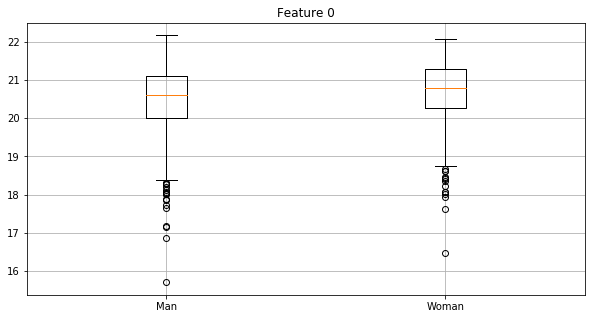

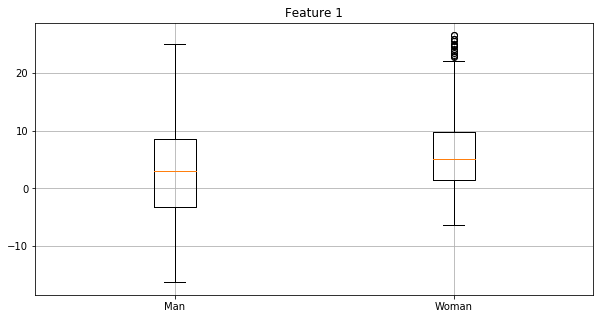

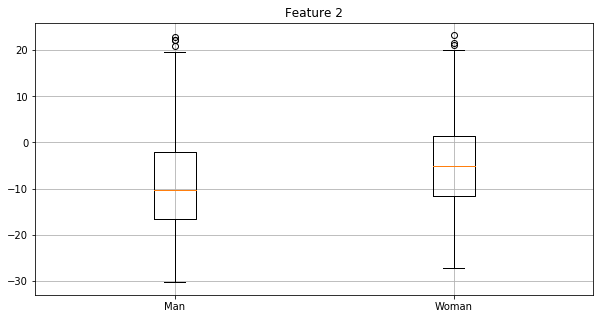

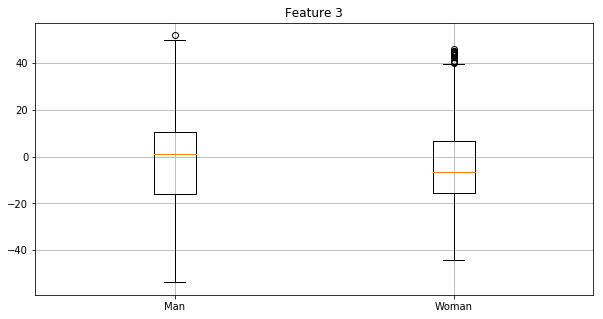

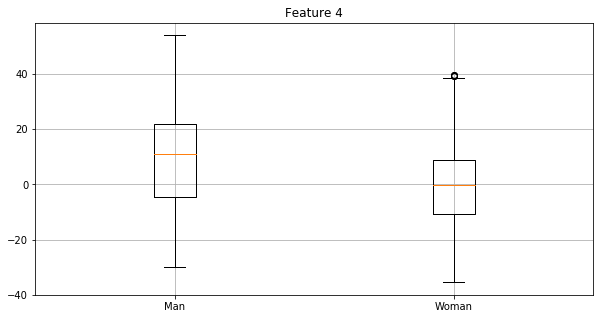

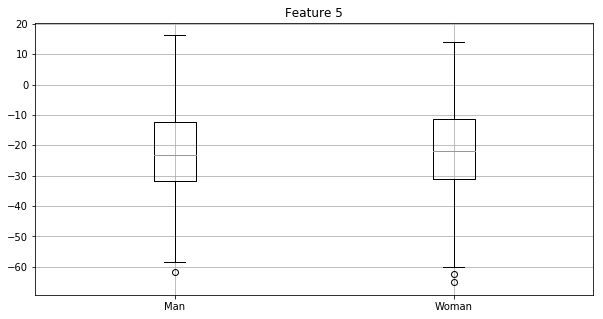

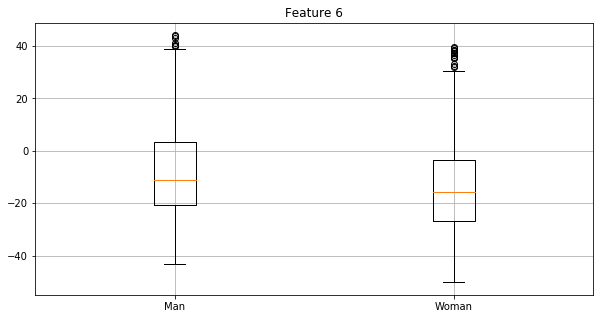

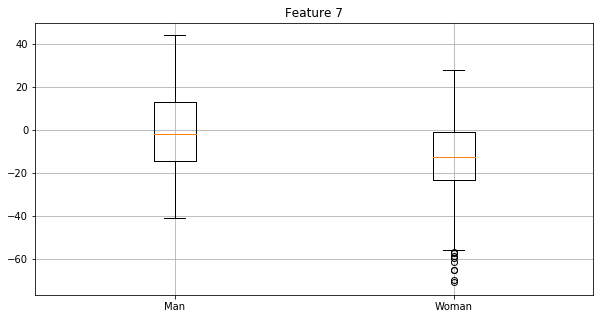

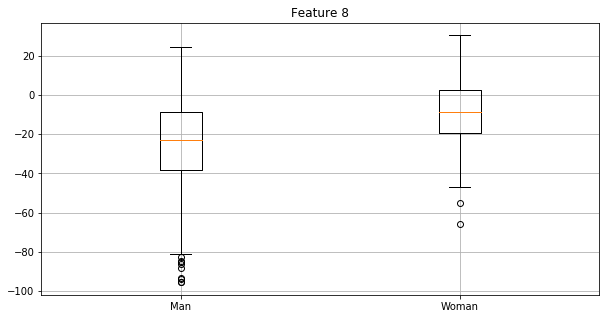

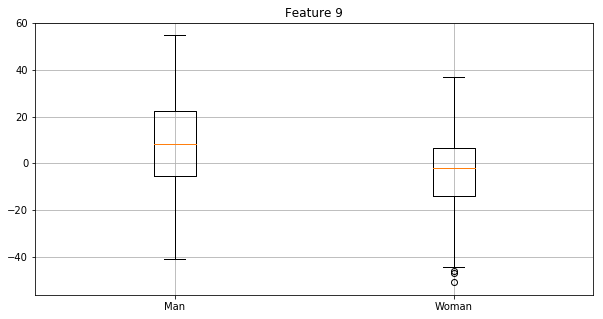

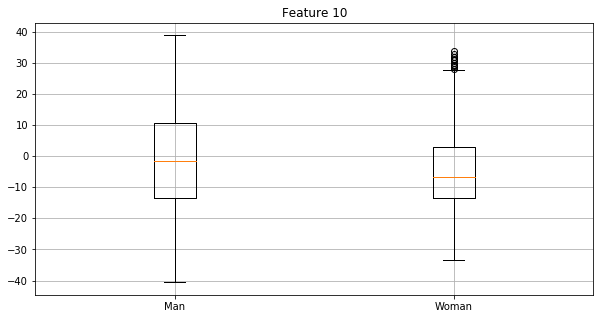

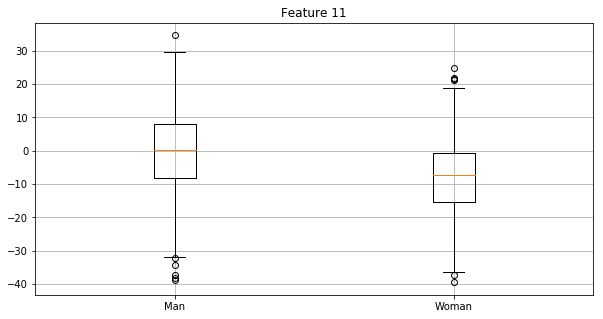

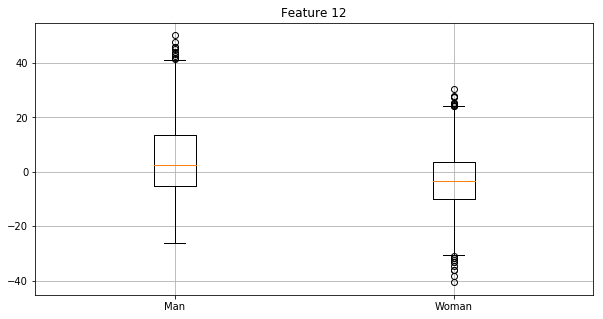

In [8]:
def boxplot_feature(m_features, f_features, k):
    pl.figure(figsize=(10,5))
    feature = np.array([m_features[k], f_features[k]])
    pl.boxplot(feature)
    pl.title('Feature '+ str(k))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

for f in np.arange(13):
    boxplot_feature(men_aligned, women_aligned, f)


### Plotting the features, average per audio

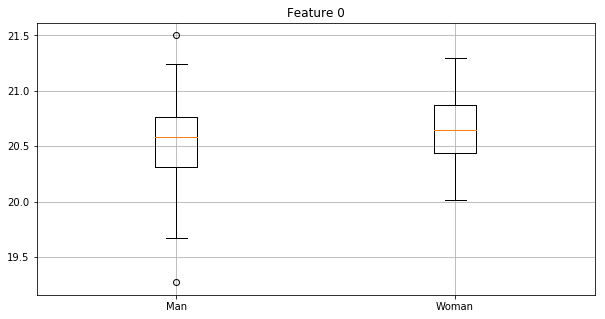

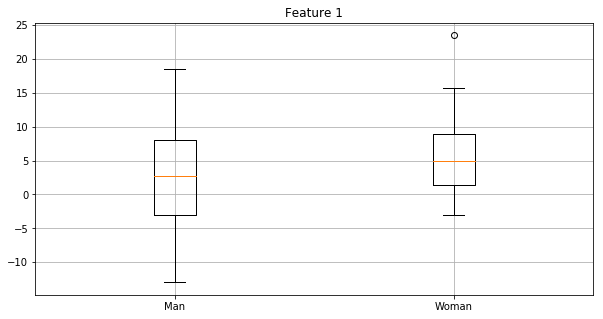

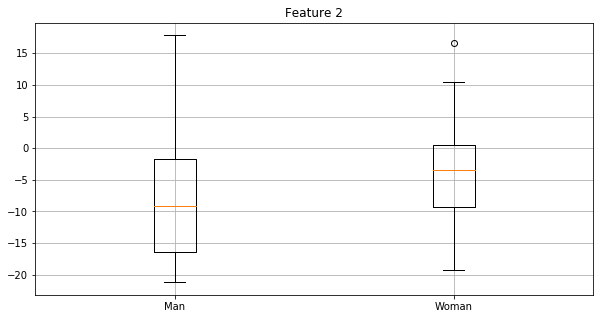

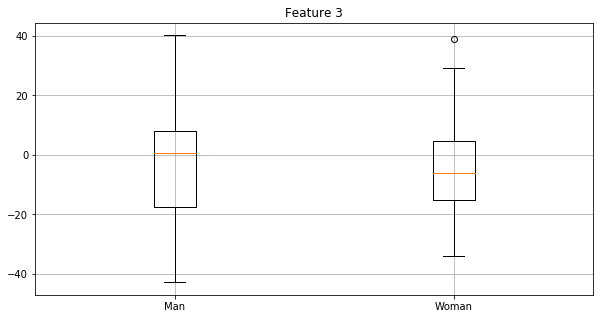

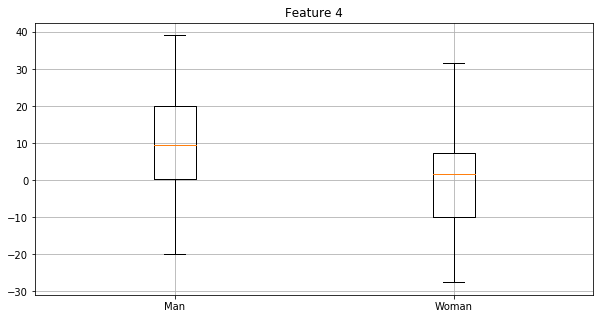

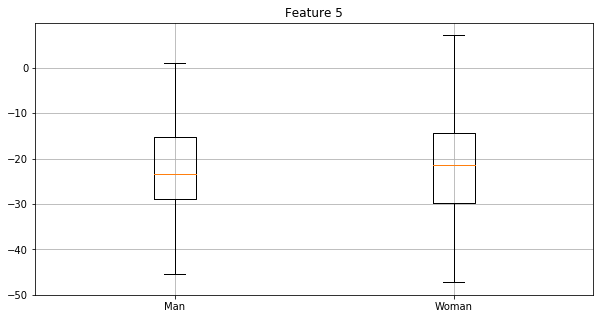

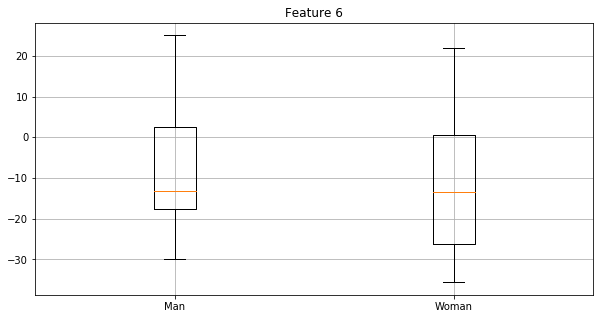

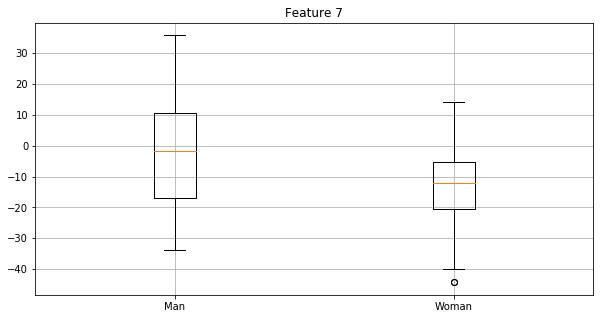

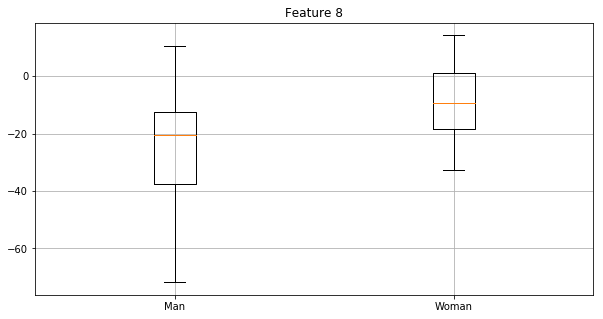

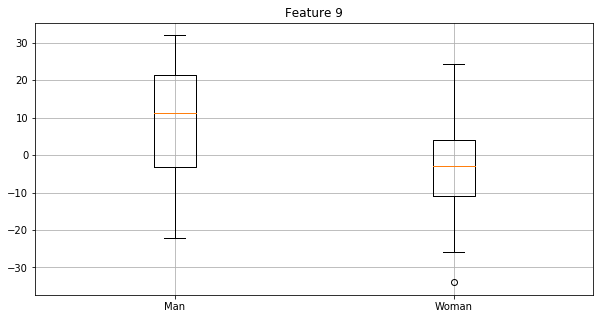

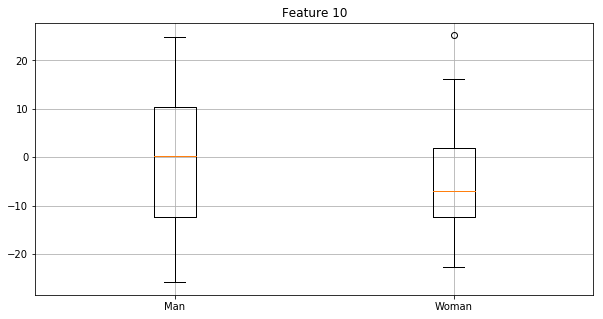

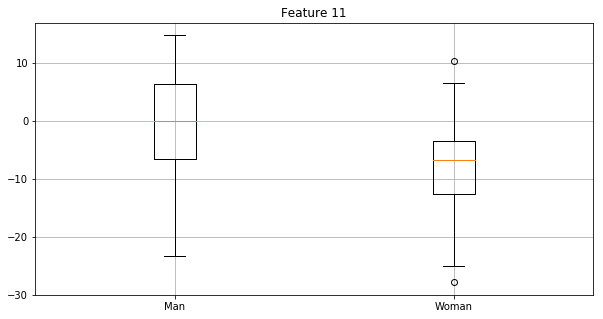

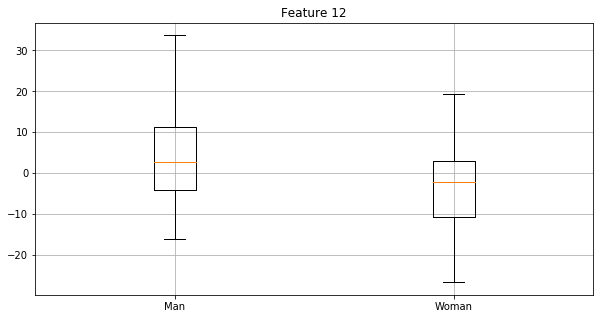

In [9]:
for f in np.arange(N_FEATURES):
    pl.figure(figsize=(10,5))
    pl.boxplot([men_avg.T[f], women_avg.T[f]])
    pl.title('Feature '+ str(f))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

Features 2, 3, 4, 8, 9 look the most distinguishable between men and women.  
But using all the features lead to the better model performance. Thus, we are using all the features as the input layer of the NN.

In [10]:
# note: features are indexed from 0 to 12
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
def create_dataset(m_features, f_features, feature_indexes):
    extracted = np.zeros((len(m_features[0]) + len(f_features[0]), len(feature_indexes)+1))
    for i, fi in enumerate(feature_indexes):
        extracted[:, i] = np.concatenate((m_features[fi], f_features[fi]))
    extracted[:, extracted.shape[1]-1] = np.concatenate((np.ones(len(m_features[0])), -1*np.ones(len(f_features[0]))))
    return extracted

In [12]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

In [13]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 5, 8, 16]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

Tests take too much time, because we consider every fragment.  
To reduce the calculation time, we can reduce the number of inputs (features considered) or reduce the size of the dataset. 
Since we cannot be sure about which features are the best for our classification problem, it will probably be more convinient to reduce the size of the dataset. We first thought of using the average value of the feature per audio. But this method reduces the dataset to only 36 values per feature per class. In addition, using average value can maybe lead to underfitting.  
Instead of considering every fragment, we will normalize the data for every feature: we will create a normally distributed dataset of size *n* for every feature.  
NOTE: After executing several test on different models, this simplification was discarded.

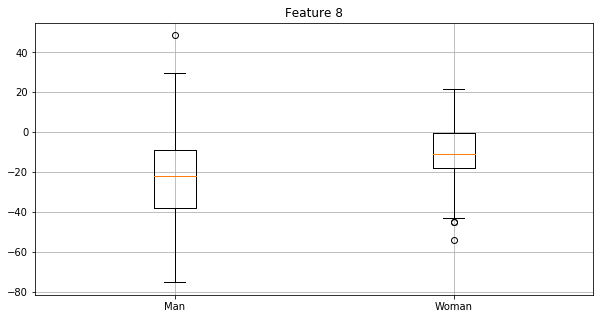

In [14]:
# NOT USED FOR THE FINAL MODELS
import statistics

def normalize_data(feature_set, n):
    '''
    feature_set has to be an array of length N_FEATURES
    every kth element of this array is the list containing the valeus of the kth feature of all fragments (aligned)
    n : number of points
    '''
    result = np.zeros((N_FEATURES, n))
    for f, values in enumerate(feature_set):
        sd = statistics.stdev(values)
        m = statistics.mean(values)
        normalized = np.random.normal(m, sd, n)
        result[f, :] = normalized
    return result

men_normalized = normalize_data(men_aligned, 200)
women_normalized = normalize_data(women_aligned, 200)

# plot some feature 
pl.figure(figsize=(10,5))
pl.boxplot([men_normalized[8], women_normalized[8]])
pl.title('Feature '+ str(8))
pl.xticks([1, 2], ['Man', 'Woman'])
pl.grid()

In [15]:
N_INITS = 10
N_TESTS = 10
K = 5
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 20, 25, 30, 40]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [16]:
mf_dataset = create_dataset(men_aligned, women_aligned, selected_features)
input_size = len(selected_features)
print(mf_dataset.shape)

(1672, 14)


In [17]:
# MOMENTUM_LIST = np.arange(0.1, 0.95, 0.2)
# LEARNING_RATE_LIST =np.arange(0.001, 1, 0.1)
MOMENTUM_LIST = np.array([0.1, 0.3, 0.7, 0.9])
LEARNING_RATE_LIST = np.array([0.001, 0.01, 0.1, 0.2, 0.3])
PATH_EXPERIMENTS = './experiments/'
PATH_MW = PATH_EXPERIMENTS + 'MW/'

In [18]:
# NOTE: the result of these experiments is listed in ./experiments/MW
# Every file contains a 3-dimensional numpy array of shape ((len(N_NEURONS), EPOCHS, N_TESTS))    
# File name convention: 
# Every file is named as follows: {X}_M{Y}L{Z}N{K}_test.npy or {X}_M{Y}L{Z}N{K}_train.npy
#     - X is the index of the experiment, test and train files with the same index correspond to the same experiment
#     - Y is the Momentum used for the experiment
#     - Z is the Learning rate used for the experiment
# Numer of EPOCHS = 100
# Number of tests N_TESTS = 10

# cnt = 0
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             mf_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=EPOCHS)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_MW + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_MW + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

### Learning Rate

MOMENTUM=0.1, LEARNING RATE=0.001


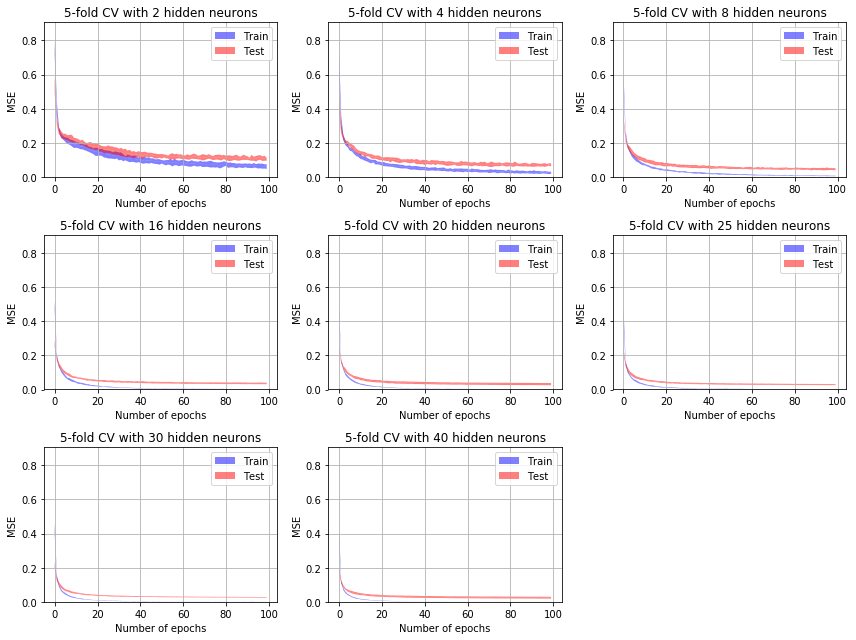

In [19]:
print("MOMENTUM=0.1, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '0_M0.1L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '0_M0.1L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.1, LEARNING RATE=0.1


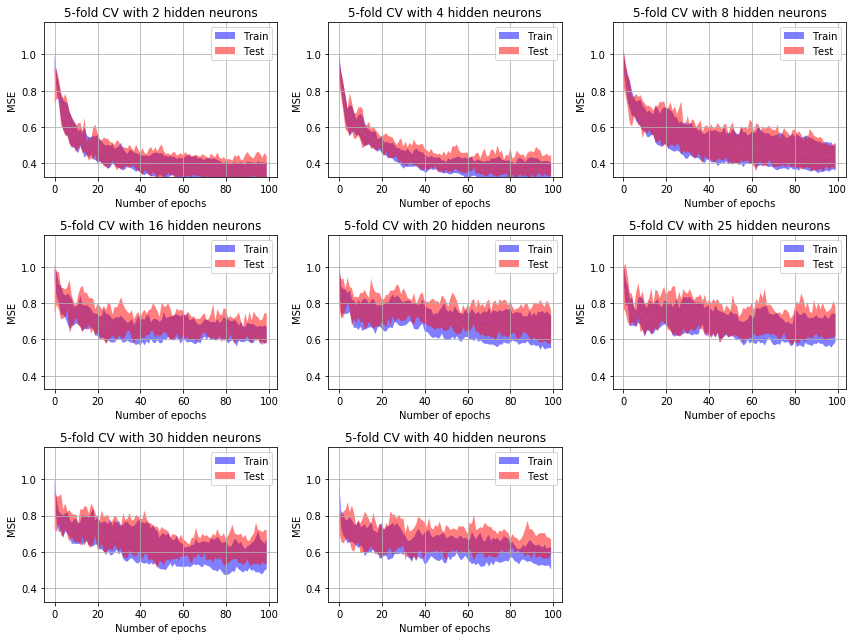

In [20]:
print("MOMENTUM=0.1, LEARNING RATE=0.1")
MSE_train = np.load(PATH_MW + '2_M0.1L0.1N40_train.npy')
MSE_test = np.load(PATH_MW + '2_M0.1L0.1N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

### Momentum

MOMENTUM=0.3, LEARNING RATE=0.001


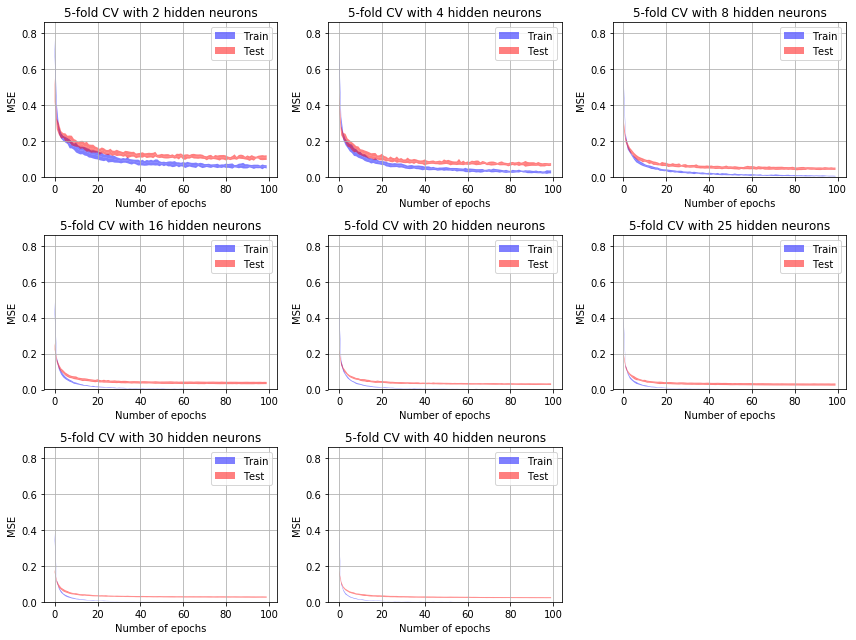

In [21]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '5_M0.3L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '5_M0.3L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.7, LEARNING RATE=0.001


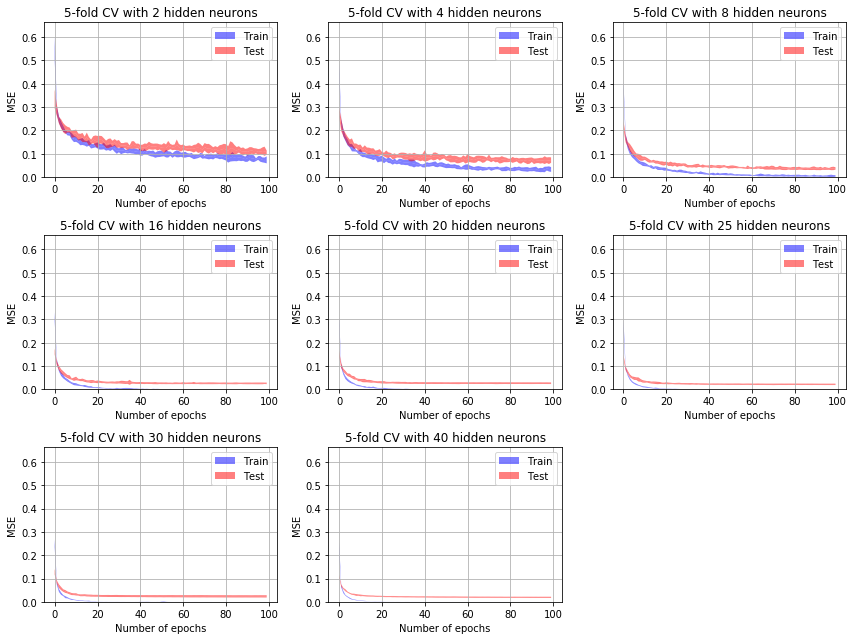

In [22]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '10_M0.7L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '10_M0.7L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

### Number of neurons in the hidden layer

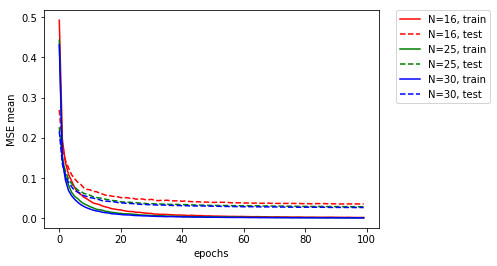

In [23]:
MSE_train = np.load(PATH_MW + '0_M0.1L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '0_M0.1L0.001N40_test.npy')

# 16 neursons
MSE_train_N16 = MSE_train[3, :, :]
MSE_test_N16 = MSE_test[3, :, :]
MSE_train_N16_mean = np.mean(MSE_train_N16, axis=1)
MSE_test_N16_mean = np.mean(MSE_test_N16, axis=1)

# 25 neurons
MSE_train_N25 = MSE_train[5, :, :]
MSE_test_N25 = MSE_test[5, :, :]
MSE_train_N25_mean = np.mean(MSE_train_N25, axis=1)
MSE_test_N25_mean = np.mean(MSE_test_N25, axis=1)

# 30 neurons
MSE_train_N30 = MSE_train[6, :, :]
MSE_test_N30 = MSE_test[6, :, :]
MSE_train_N30_mean = np.mean(MSE_train_N30, axis=1)
MSE_test_N30_mean = np.mean(MSE_test_N30, axis=1)

pl.plot(MSE_train_N16_mean, 'r', label='N=16, train')
pl.plot(MSE_test_N16_mean, 'r--',label='N=16, test')
pl.plot(MSE_train_N25_mean, 'g', label='N=25, train')
pl.plot(MSE_test_N25_mean, 'g--',label='N=25, test')
pl.plot(MSE_train_N30_mean, 'b', label='N=30, train')
pl.plot(MSE_test_N30_mean, 'b--',label='N=30, test')
pl.xlabel('epochs')
pl.ylabel('MSE mean')
pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### The final model

In [ ]:
# Final hyperparameters:
M = 0.1      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 25       # number of neurons
N_TESTS = 10 # number of tests

In [ ]:
mw_nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [ ]:
mw_MSE_train, mw_MSE_test, mw_conf_mat = cv.k_fold_cross_validation(mw_nn,
                                                                    mf_dataset,
                                                                    k=K,
                                                                    learning_rate=L,
                                                                    momentum=M,
                                                                    epochs=E,
                                                                    threshold=0.0)

In [ ]:
print('MSE training: ', mw_MSE_train)
print('MSE test: ', mw_MSE_test)
print('Confusion matrix:')
print(mw_conf_mat)

### Prediciton tests

In [ ]:
def mf_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a man or woman voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1200)
    p = 0
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = mw_nn.predict(f)
        p += p_i
    # calculate the average prediction
    if(p > 0):
        return "Man"
    else:
        return "Woman"

In [ ]:
mf_predict('nafdloo.wav') # natural female

In [ ]:
mf_predict('safkgil.wav') # synthetized female

In [ ]:
mf_predict('namcraa.wav') # natural male

In [ ]:
mf_predict('sampher.wav') # synthetized male

In [ ]:
mf_predict('nk7bruu.wav') # natual kid

In [ ]:
mf_predict('sk7brer.wav') # synthetized kid

In [ ]:
mf_predict('samphil.wav') # synthetized male

In [ ]:
mf_predict('samshoo.wav') # synthetized male

In [ ]:
mf_predict('samshuu.wav') 

In [ ]:
mf_predict('safshal.wav')

In [ ]:
mf_predict('safkgoo.wav')

In [ ]:
mf_predict('samshul.wav')

In [ ]:
mf_predict('namcril.wav')

In [ ]:
mf_predict('namphii.wav')

In [ ]:
mf_predict('nafdluh.wav')

In [ ]:
mf_predict('nafkger.wav')

In [ ]:
mf_predict('custom/sasha.wav')

In [ ]:
mf_predict('custom/sam1.wav')

In [ ]:
mf_predict('custom/sam2.wav')

In [ ]:
mf_predict('custom/joe_rogan.wav')

In [ ]:
mf_predict('custom/ksu.wav')

## Woman vs Kid

Extract audios corresponding to the women's and kids' voices and calculate the features

In [ ]:
k_features = [] # array containing all features of the kids' (natural) voices
f_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 2): 
        k_features.append(f[0])
    elif(f[1] == 1):
        f_features.append(f[0]) 
m_features = np.array(m_features)
f_features = np.array(f_features)

In [ ]:
# Final hyperparameters:
M = 0.1      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 25       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Align by feature

In [ ]:
kids_aligned = align_by_feature(k_features)
women_aligned = align_by_feature(f_features)

Create the dataset. Now the output for the kid's voice will be 1 and the output for the woman's voice will remain -1.

In [ ]:
wk_dataset = create_dataset(kids_aligned, women_aligned, selected_features)

In [ ]:
wk_nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [ ]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(wk_nn,
                                                          wk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [ ]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

In [ ]:
MOMENTUM_LIST = [0.1, 0.3, 0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [30, 40]
EPOCHS = E
PATH_WK = PATH_EXPERIMENTS + 'WK/'

In [ ]:
# The results of these experiment are listed in ./experiments/WK directory

# cnt = 3
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

### Learning rate, Momentum, Numer of Neurons in the hidden layer

In [ ]:
print("MOMENTUM=0.1, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '0_M0.1L0.001N30_train.npy')
MSE_test = np.load(PATH_WK + '0_M0.1L0.001N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.1, LEARNING RATE=0.01")
MSE_train = np.load(PATH_WK + '1_M0.1L0.01N30_train.npy')
MSE_test = np.load(PATH_WK + '1_M0.1L0.01N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '2_M0.3L0.001N30_train.npy')
MSE_test = np.load(PATH_WK + '2_M0.3L0.001N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '5_M0.5L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '5_M0.5L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

The MSE gets better when the value of momentum grows. We will execute some tests with a higher value of momentum and more neurons in the hidden layer

In [ ]:
MOMENTUM_LIST = [0.7, 0.9]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [30, 40]

In [ ]:
# The results of these experimenst are listed in ./experiments/WK

# cnt = 6
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

In [ ]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '6_M0.7L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '6_M0.7L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.9, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '7_M0.9L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '7_M0.9L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
MOMENTUM_LIST = [0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [40, 50]
EPOCHS = 100
E = 100

In [ ]:
# The results of these experiments are listed in ./experiments/WK

# cnt = 8
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

In [ ]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '8_M0.5L0.001N50_train.npy')
MSE_test = np.load(PATH_WK + '8_M0.5L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

__Final Model__

In [ ]:
# Final hyperparameters:
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 40       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
wk_nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [ ]:
wk_MSE_train, wk_MSE_test, wk_conf_mat = cv.k_fold_cross_validation(wk_nn,
                                                                    wk_dataset,
                                                                    k=K,
                                                                    learning_rate=L,
                                                                    momentum=M,
                                                                    epochs=E,
                                                                    threshold=0.0)

In [ ]:
print('MSE training: ', wk_MSE_train)
print('MSE test: ', wk_MSE_test)
print('Confusion matrix:')
print(wk_conf_mat)

In [ ]:
def wk_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a woman or kid voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1200)
    p = 0
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = wk_nn.predict(f)
        p += p_i
    # calculate the average prediction
    if(p > 0):
        return "Kid"
    else:
        return "Woman"

In [ ]:
wk_predict('nafdlaa.wav')

In [ ]:
wk_predict('nafdlel.wav')

In [ ]:
wk_predict('nafdluh.wav')

In [ ]:
wk_predict('nk3ajil.wav')

In [ ]:
wk_predict('nk3araa.wav')

In [ ]:
wk_predict('nk3kmaw.wav')

In [ ]:
wk_predict('nk3kmer.wav')

In [ ]:
wk_predict('safdluu.wav')

In [ ]:
wk_predict('safkgal.wav')

In [ ]:
wk_predict('safkgul.wav')

In [ ]:
wk_predict('sk3ajaa.wav')

In [ ]:
wk_predict('sk3ajer.wav')

In [ ]:
wk_predict('sk3araa.wav')

In [ ]:
wk_predict('sk3araw.wav')

In [ ]:
wk_predict('namphaa.wav')

In [ ]:
wk_predict('namphee.wav')

In [ ]:
wk_predict('samcral.wav')

In [ ]:
wk_predict('samcree.wav')

In [ ]:
wk_predict('custom/ksu.wav')

In [ ]:
wk_predict('custom/sasha.wav')

In [ ]:
wk_predict('custom/sam.wav')

In [ ]:
wk_predict('custom/joe_rogan.wav')

## Man vs Woman vs Kid

In [ ]:
print(len(men_aligned[0]))
print(len(men_aligned[1]))
print(len(women_aligned[0]))
print(len(women_aligned[1]))
print(len(kids_aligned[0]))
print(len(kids_aligned[1]))
print(selected_features)

In [ ]:
# create a dataset with 2 outputs for the 3-classes classifier
def create_dataset_2(m_aligned, w_aligned, k_aligned, selected_features):
    '''
    output layer:
        - man: [1, 1]
        - woman [-1, -1]
        - kid: [1, -1]
    '''
    m_len = len(m_aligned[0])
    w_len = len(w_aligned[0])
    k_len = len(k_aligned[0])
    extracted = np.zeros(((m_len+w_len+k_len), len(selected_features)+2))
    for i, fi in enumerate(selected_features):
        extracted[:, i] = np.concatenate((m_aligned[fi], w_aligned[fi], k_aligned[fi]))
    # first output nodes
    extracted[:, extracted.shape[1]-2] = np.concatenate((np.ones(m_len), -1*np.ones(w_len), np.ones(k_len)))
    extracted[:, extracted.shape[1]-1] = np.concatenate((np.ones(m_len), -1*np.ones(w_len), -1*np.ones(k_len)))
    return extracted

In [ ]:
mwk_dataset = create_dataset_2(men_aligned, women_aligned, kids_aligned, selected_features)

In [ ]:
mwk_dataset.shape

In [ ]:
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 40       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
mwk_nn = mlp.MLP([N_FEATURES,N,2], 'tanh')

In [ ]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(mwk_nn,
                                                          mwk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [ ]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

In [ ]:
MOMENTUM_LIST = [0.3, 0.5, 0.7]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [40, 50]
EPOCHS = E
PATH_MWK = PATH_EXPERIMENTS + 'MWK/'

In [ ]:
# The results of these experiments are listed in ./experiments/MWK

# cnt = 0
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

In [ ]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '0_M0.3L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '0_M0.3L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '1_M0.5L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '1_M0.5L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '2_M0.7L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '2_M0.7L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
MOMENTUM_LIST = [0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [50, 60]
EPOCHS = E
PATH_MWK = PATH_EXPERIMENTS + 'MWK/'

In [ ]:
# The results of these experiments are listed in ./experiments/MWK

# cnt = 3
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

In [ ]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '3_M0.5L0.001N60_train.npy')
MSE_test = np.load(PATH_MWK + '3_M0.5L0.001N60_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

__Final Model__

In [ ]:
# Final configuration
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 50       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
mwk_nn = mlp.MLP([N_FEATURES,N,2], 'tanh')

In [ ]:
mwk_MSE_train, mwk_MSE_test, mwk_conf_mat = cv.k_fold_cross_validation(mwk_nn,
                                                                       mwk_dataset,
                                                                       k=K,
                                                                       learning_rate=L,
                                                                       momentum=M,
                                                                       epochs=E,
                                                                       threshold=0.0)

In [ ]:
print('MSE training: ', mwk_MSE_train)
print('MSE test: ', mwk_MSE_test)
print('Confusion matrix:')
print(mwk_conf_mat)

In [ ]:
def mwk_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a man's, woman's or kid's voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1220)
    score = np.zeros(2)
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = mwk_nn.predict(f)
        score = np.sum([score, p_i], axis=0)
    if(score[0] < 0 and score[1] < 0 ):
        return 'Woman'
    elif (score[0] > 0 and score[1] < 0):
        return 'Kid'
    elif (score[0] > 0 and score[1] > 0):
        return 'Man'
    else:
        return 'Undefined' # chances to reproduce is almost 0

In [ ]:
mwk_predict('nafdlaa.wav')

In [ ]:
mwk_predict('nafdlel.wav')

In [ ]:
mwk_predict('nafdluu.wav')

In [ ]:
mwk_predict('namphuh.wav')

In [ ]:
mwk_predict('namshaw.wav')

In [ ]:
mwk_predict('namshuh.wav')

In [ ]:
mwk_predict('nk3ajaw.wav')

In [ ]:
mwk_predict('nk3ajuh.wav')

In [ ]:
mwk_predict('nk3kmer.wav')

In [ ]:
mwk_predict('nk7braw.wav')

In [ ]:
mwk_predict('safdlaw.wav')

In [ ]:
mwk_predict('safdlil.wav')

In [ ]:
mwk_predict('safshii.wav')

In [ ]:
mwk_predict('sampher.wav')

In [ ]:
mwk_predict('samshaa.wav')

In [ ]:
mwk_predict('samshel.wav')

In [ ]:
mwk_predict('sk3ajaw.wav')

In [ ]:
mwk_predict('sk3ajoo.wav')

In [ ]:
mwk_predict('sk5mgaw.wav')

In [ ]:
mwk_predict('custom/sam2.wav')

In [ ]:
mwk_predict('custom/sasha.wav')

In [ ]:
mwk_predict('custom/sam.wav')

In [ ]:
mwk_predict('custom/sam1.wav')

In [ ]:
mwk_predict('custom/joe_rogan.wav')

In [ ]:
mwk_predict('custom/ksu.wav')

In [ ]:
mwk_predict('custom/danya.wav')

## Natural vs Synthetized

__Data Extraction__

In [ ]:
n_features = [] # array containing all features of the kids' (natural) voices
s_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 0 or f[1] == 1 or f[1] == 2): 
        n_features.append(f[0])
    elif(f[1] == 3 or f[1] == 4 or f[1] == 5):
        s_features.append(f[0]) 
n_features = np.array(n_features)
s_features = np.array(s_features)

nat_aligned = align_by_feature(n_features)
syn_aligned = align_by_feature(s_features)

selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# output: 1 for natural, -1 for synthetized voices
ns_dataset = create_dataset(nat_aligned, syn_aligned, selected_features)

ns_dataset.shape

__Tests__

In [ ]:
MOMENTUM_LIST = [0.1, 0.3, 0.5]
LEARNING_RATE_LIST = [0.001]
E = 70
EPOCHS = E
N_NEURONS = [25, 35, 45]
N_TESTS = 10
K = 5
PATH_NS = PATH_EXPERIMENTS + 'NS/'
input_size = len(selected_features)

In [ ]:
# The results of these experiments are listed in ./experiments/NS

# cnt = 0
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             ns_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=E)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_NS + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_NS + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

In [ ]:
print("MOMENTUM=0.1, LEARNING RATE=0.001")
MSE_train = np.load(PATH_NS + '0_M0.1L0.001N45_train.npy')
MSE_test = np.load(PATH_NS + '0_M0.1L0.001N45_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 0.3*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_NS + '1_M0.3L0.001N45_train.npy')
MSE_test = np.load(PATH_NS + '1_M0.3L0.001N45_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 0.3*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_NS + '2_M0.5L0.001N45_train.npy')
MSE_test = np.load(PATH_NS + '2_M0.5L0.001N45_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 0.3*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

__Final Model__

In [ ]:
# Final hyperparameters:
M = 0.1      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 45      # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
ns_nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [ ]:
ns_MSE_train, ns_MSE_test, ns_conf_mat = cv.k_fold_cross_validation(ns_nn,
                                                                    ns_dataset,
                                                                    k=K,
                                                                    learning_rate=L,
                                                                    momentum=M,
                                                                    epochs=E,
                                                                    threshold=0.0)

In [ ]:
print('MSE training: ', ns_MSE_train)
print('MSE test: ', ns_MSE_test)
print('Confusion matrix:')
print(ns_conf_mat)

In [ ]:
def ns_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a natural or synthetized voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1200)
    p = 0
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = ns_nn.predict(f)
        p += p_i
    # calculate the average prediction
    if(p > 0):
        return "Natural"
    else:
        return "Synthetized"

In [ ]:
ns_predict('nafdlaa.wav')

In [ ]:
ns_predict('nafdlel.wav')

In [ ]:
ns_predict('nafdluu.wav')

In [ ]:
ns_predict('namcraw.wav')

In [ ]:
ns_predict('namcraa.wav')

In [ ]:
ns_predict('namcrii.wav')

In [ ]:
ns_predict('nk3araa.wav')

In [ ]:
ns_predict('nk3arer.wav')

In [ ]:
ns_predict('nk3kmaa.wav')

In [ ]:
ns_predict('samphal.wav')

In [ ]:
ns_predict('samshee.wav')

In [ ]:
ns_predict('samshuh.wav')

In [ ]:
ns_predict('sk3ajaw.wav')

In [ ]:
ns_predict('sk3ajul.wav')

In [ ]:
ns_predict('custom/sam.wav')

In [ ]:
ns_predict('custom/sasha.wav')

In [ ]:
ns_predict('custom/ksu.wav')

In [ ]:
ns_predict('custom/joe_rogan.wav')

In [ ]:
ns_predict('custom/danya.wav')

## Performance Measures

In [ ]:
def performance(conf_mat):
    tp = conf_mat[0][0]
    tn = conf_mat[1][1]
    fp = conf_mat[1][0]
    fn = conf_mat[0][1]
    acc  = float(tp+tn)/(tp+tn+fp+fn) # accuracy
    prec = float(tp)/(tp+fp)          # precision
    rec  = float(tp)/(tp+fn)          # recall
    f1   = prec*rec/(prec+rec)        # f1 score
    return {'acc': acc, 'p': prec, 'r': rec, 'f1': f1}

In [ ]:
performance(mw_conf_mat)

In [ ]:
performance(wk_conf_mat)

In [ ]:
performance(mwk_conf_mat)

In [ ]:
performance(ns_conf_mat)

## Custom experiment

Cutom Natural Male voices

In [ ]:
mf_predict('custom/danya.wav')

In [ ]:
mf_predict('custom/joe_rogan.wav')

In [ ]:
mf_predict('custom/sam.wav')

In [ ]:
mf_predict('custom/sam1.wav')

In [ ]:
mf_predict('custom/sam2.wav')

In [ ]:
wk_predict('custom/danya.wav')

In [ ]:
wk_predict('custom/joe_rogan.wav')

In [ ]:
wk_predict('custom/sam.wav')

In [ ]:
wk_predict('custom/sam1.wav')

In [ ]:
wk_predict('custom/sam2.wav')

In [ ]:
mwk_predict('custom/danya.wav')

In [ ]:
mwk_predict('custom/joe_rogan.wav')

In [ ]:
mwk_predict('custom/sam.wav')

In [ ]:
mwk_predict('custom/sam1.wav')

In [ ]:
mwk_predict('custom/sam2.wav')

In [ ]:
ns_predict('custom/danya.wav')

In [ ]:
ns_predict('custom/joe_rogan.wav')

In [ ]:
ns_predict('custom/sam.wav')

In [ ]:
ns_predict('custom/sam1.wav')

In [ ]:
ns_predict('custom/sam2.wav')

Custom Natural Female voices

In [ ]:
mf_predict('custom/sasha.wav')

In [ ]:
mf_predict('custom/ksu.wav')

In [ ]:
wk_predict('custom/sasha.wav')

In [ ]:
wk_predict('custom/ksu.wav')

In [ ]:
mwk_predict('custom/sasha.wav')

In [ ]:
mwk_predict('custom/ksu.wav')

In [ ]:
ns_predict('custom/sasha.wav')

In [ ]:
ns_predict('custom/ksu.wav')

__Audios comparison__

In [ ]:
sample_rate_danya, X_danya = wav.read(os.path.join(PATH, 'custom/danya.wav'))
sample_rate_joe, X_joe = wav.read(os.path.join(PATH, 'custom/joe_rogan.wav'))
sample_rate_sam, X_sam = wav.read(os.path.join(PATH, 'custom/sam2.wav'))
sample_rate_sasha, X_sasha = wav.read(os.path.join(PATH, 'custom/sasha.wav'))
sample_rate_ksu, X_ksu = wav.read(os.path.join(PATH, 'custom/ksu.wav'))
sample_rate_nm, X_nm = wav.read(os.path.join(PATH, 'namcraw.wav'))
sample_rate_nf, X_nf = wav.read(os.path.join(PATH, 'nafshil.wav'))

In [ ]:
# danya
pl.figure(figsize=(15, 6))
pl.plot(X_danya)
pl.xlim(0, len(X_danya))
pl.title('X_danya')
pl.grid()

In [ ]:
# joe rogan
pl.figure(figsize=(15, 6))
pl.plot(X_joe)
pl.xlim(0, len(X_joe))
pl.title('X_joe')
pl.grid()

In [ ]:
# sam
pl.figure(figsize=(15, 6))
pl.plot(X_sam)
pl.xlim(0, len(X_sam))
pl.title('X_sam')
pl.grid()
pl.tight_layout()

In [ ]:
# sasha
pl.figure(figsize=(15, 6))
pl.plot(X_sasha)
pl.xlim(0, len(X_sasha))
pl.title('X_sasha')
pl.grid()
pl.tight_layout()

In [ ]:
# ksu
pl.figure(figsize=(15, 6))
pl.plot(X_ksu)
pl.xlim(0, len(X_ksu))
pl.title('X_ksu')
pl.grid()
pl.tight_layout()

In [ ]:
# Natural Adult Male
pl.figure(figsize=(15, 6))
pl.plot(X_nm)
pl.xlim(0, len(X_nm))
pl.title('X_Natural_Male')
pl.grid()

In [ ]:
# Natural Adult Female
pl.figure(figsize=(15, 6))
pl.plot(X_nf)
pl.xlim(0, len(X_nf))
pl.title('X_Natural_Femaale')
pl.grid()